## Preparar Dados

#### Bibliotecas nescessárias

In [35]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

#### Definir a Classe Dataset

In [36]:
class CustomDataset(Dataset):
    def __init__(self, data, labels) -> None:
        super().__init__()
        self.data = data.to_numpy()
        self.labels = labels.to_numpy()

    def __len__(self):
        return self.labels.size
        
    def __getitem__(self, index):
        x, y = self.data[index], self.labels[index]
        return x, y
    


In [37]:
file_path = os.path.join('..', 'data', 'interferome.csv')
df = pd.read_csv(file_path)

In [58]:
df.head(3600)

,Unnamed: 0,att_1,att_2,att_3,att_4,out_1,out_2
0,0,0.0,0.0,0.000000,0.000000,1.0,0.0
1,1,0.0,0.0,0.000000,0.314159,1.0,0.0
2,2,0.0,0.0,0.000000,0.471239,1.0,0.0
3,3,0.0,0.0,0.000000,0.628319,1.0,0.0
4,4,0.0,0.0,0.000000,0.785398,1.0,0.0
...,...,...,...,...,...,...,...
3595,3595,1.0,0.0,1.570796,5.654867,1.0,0.0
3596,3596,1.0,0.0,1.570796,5.811946,1.0,0.0
3597,3597,1.0,0.0,1.570796,5.969026,1.0,0.0
3598,3598,1.0,0.0,1.570796,6.126106,1.0,0.0


Vamos selecionar os primeiros 4 atributos e saída para treinar o modelo (incentivo a usarem a saída 2
 e retreinar)

In [39]:
x = df[['att_1', 'att_2', 'att_3', 'att_4']]
y = df[['out_1']]

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2,random_state=42)

Criar DataSets

In [40]:
dataset_train = CustomDataset(xTrain, yTrain)
dataset_test = CustomDataset(xTest, yTest)

Criar DataLoaders

In [41]:
batch_size = 32
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test)

## Modelo

#### Bibliotecas nescessárias

In [42]:
from torch import nn

#### Definir arquitetura da rede

In [43]:
class NN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Sequential(
            nn.Linear(4, 8),            
            nn.ReLU(),
            nn.Dropout(p=0.8),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4, 2),
            nn.ReLU(),
            nn.Linear(2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.layer1(x)
        return logits

## Treinamento

#### Bibliotecas nescessárias

In [44]:
import torch

#### Definir funções de treinamento

In [45]:
def train_loop(dataloader, model, loss_function, optimizer, device='cpu'):
    size = len(dataloader.dataset)
    batch_size = int(len(dataloader.dataset) / len(dataloader))
    model.train()
    epoch_loss, epoch_accuracy = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device).type(torch.float32), y.to(device).type(torch.float32)

        output = model(X)  # Saída com a probabilidade
        pred = (output >= 0.5).float()  # Classificar como 1 se probabilidade >= 0.5, senão 0
        epoch_accuracy += (pred == y).type(torch.float).sum().item()

        loss = loss_function(output, y)
        epoch_loss += loss.item()

        # Backpropagation        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (batch + 1) % batch_size == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    
    epoch_loss /= len(dataloader) # Loss mean
    epoch_accuracy /= size # Accuracy mean
    print(f"accuracy of train: {epoch_accuracy:0.7f}\n")
    return epoch_loss, epoch_accuracy

def test_loop(dataloader, model, loss_function, device='cpu'):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).type(torch.float32), y.to(device).type(torch.float32)

            output = model(X)  # Saída com a probabilidade
            pred = (output >= 0.5).float()  # Classificar como 1 se probabilidade >= 0.5, senão 0

            loss = loss_function(output, y)
            test_loss += loss.item()
            correct += (pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(correct * 100):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct

Treinamento

In [46]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print(f"device is: {device}")

device is: cuda


In [47]:
# Ajuste de Hiperparâmetros

model = NN().to(device)
learning_rate = 1e-3
loss_function = nn.BCELoss()
epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss, accuracy = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    epoch_loss, epoch_accuracy = train_loop(train_dataloader, model, loss_function, optimizer, device)
    loss.append(epoch_loss)
    accuracy.append(epoch_accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 0.814251 [ 1024/ 5120]
loss: 0.782379 [ 2048/ 5120]
loss: 0.746574 [ 3072/ 5120]
loss: 0.769143 [ 4096/ 5120]
loss: 0.723595 [ 5120/ 5120]
accuracy of train: 0.2955078

Epoch 2
-------------------------------
loss: 0.726459 [ 1024/ 5120]
loss: 0.719163 [ 2048/ 5120]
loss: 0.666168 [ 3072/ 5120]
loss: 0.591118 [ 4096/ 5120]
loss: 0.661559 [ 5120/ 5120]
accuracy of train: 0.5179687

Epoch 3
-------------------------------
loss: 0.588561 [ 1024/ 5120]
loss: 0.667265 [ 2048/ 5120]
loss: 0.794303 [ 3072/ 5120]
loss: 0.637342 [ 4096/ 5120]
loss: 0.533297 [ 5120/ 5120]
accuracy of train: 0.7152344

Epoch 4
-------------------------------
loss: 0.624285 [ 1024/ 5120]
loss: 0.522455 [ 2048/ 5120]
loss: 0.611917 [ 3072/ 5120]
loss: 0.642140 [ 4096/ 5120]
loss: 0.707057 [ 5120/ 5120]
accuracy of train: 0.7152344

Epoch 5
-------------------------------
loss: 0.532834 [ 1024/ 5120]
loss: 0.411059 [ 2048/ 5120]
loss: 0.605378 [ 3072/ 5120]
loss: 0.56748

In [48]:
import matplotlib.pyplot as plt

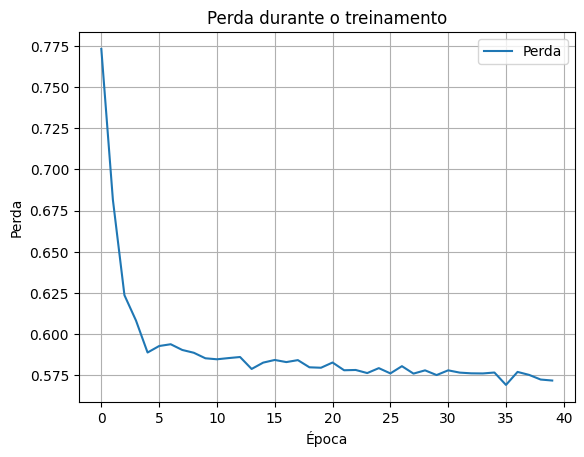

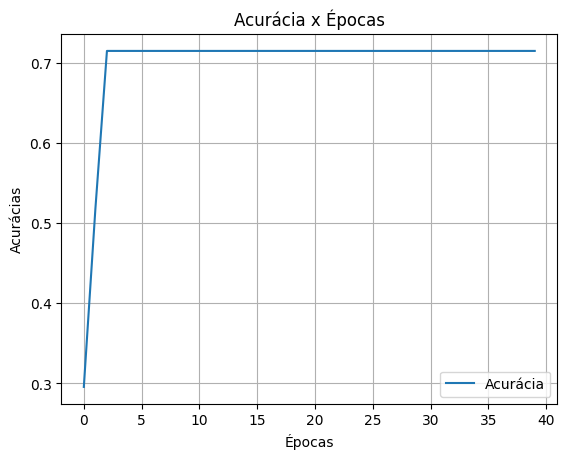

In [49]:
# Plotar em tempo real
plt.plot(range(epoch+1), loss, label='Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Perda durante o treinamento')
plt.legend()
plt.grid(True)
plt.show()

# Acurácia 
plt.plot(range(epoch+1), accuracy, label='Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácias')
plt.title('Acurácia x Épocas')
plt.legend()
plt.grid(True)
plt.show()

## Avaliar o Modelo

In [50]:
test_loop(test_dataloader, model, loss_function, device)

Test Error: 
 Accuracy: 72.4%, Avg loss: 0.535227 



72.421875